<a href="https://colab.research.google.com/github/ameranismail/DLproject-/blob/main/DLproject_CancerCerbral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Une tumeur cérébrale survient lorsque des cellules anormales se forment dans le cerveau. Il existe deux principaux types de tumeurs: les tumeurs cancéreuses (malignes) et les tumeurs bénignes. Les tumeurs cancéreuses peuvent être divisées en tumeurs primaires, qui commencent dans le cerveau, et en tumeurs secondaires, qui se sont propagées ailleurs, appelées tumeurs de métastases cérébrales. Tous les types de tumeurs cérébrales peuvent produire des symptômes qui varient selon la partie du cerveau impliquée. Ces symptômes peuvent inclure des maux de tête, des convulsions, des problèmes de vision, des vomissements et des changements mentaux. Le mal de tête est classiquement pire le matin et disparaît avec des vomissements. D'autres symptômes peuvent inclure des difficultés à marcher, à parler ou à ressentir. À mesure que la maladie progresse, une perte de conscience peut survenir.

#Téléchargement et Processing de Data 

### Se connecter à Kaggle pour telecharger la Data

In [2]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ismailameran","key":"938b12a2c98d7b24bd425f7a096913c4"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 33% 5.00M/15.1M [00:00<00:00, 48.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 73.9MB/s]


In [5]:
!unzip brain-mri-images-for-brain-tumor-detection.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

### Importer Libraries 

In [6]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

### Define Few Parameters

In [7]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]


#define paths
tumor_path = '/content/brain_tumor_dataset/yes'
notumor_path = '/content/brain_tumor_dataset/no'

# Use glob to grab images from path .jpg or jpeg
tumor_files = glob(tumor_path + '/*')
notumor_files = glob(notumor_path + '/*')

In [8]:
# Visualize file variable contents
print("First 5 tumor Files: ",tumor_files[0:5])
print("Total Count: ",len(tumor_files))
print("First 5 Notumor Files: ",notumor_files[0:5])
print("Total Count: ",len(notumor_files))

First 5 tumor Files:  ['/content/brain_tumor_dataset/yes/Y20.jpg', '/content/brain_tumor_dataset/yes/Y52.jpg', '/content/brain_tumor_dataset/yes/Y50.JPG', '/content/brain_tumor_dataset/yes/Y105.jpg', '/content/brain_tumor_dataset/yes/Y73.jpg']
Total Count:  155
First 5 Notumor Files:  ['/content/brain_tumor_dataset/no/No18.jpg', '/content/brain_tumor_dataset/no/38 no.jpg', '/content/brain_tumor_dataset/no/N16.jpg', '/content/brain_tumor_dataset/no/3 no.jpg', '/content/brain_tumor_dataset/no/N22.JPG']
Total Count:  98


### Fetch Images and Class Labels from Files (This might take a while)

In [9]:
# Fetch Images and Class Labels from Files
tumor_labels = []
notumor_labels = []

tumor_images=[]
notumor_images=[]

for i in range(len(tumor_files)):
  image = cv2.imread(tumor_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  tumor_images.append(image) # append image
  tumor_labels.append('MRI_TUMOR') #append class label
for i in range(len(notumor_files)):
  image = cv2.imread(notumor_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  notumor_images.append(image)
  notumor_labels.append('MRI_NoTUMOR')

### Visualize First 10 Images from Data set

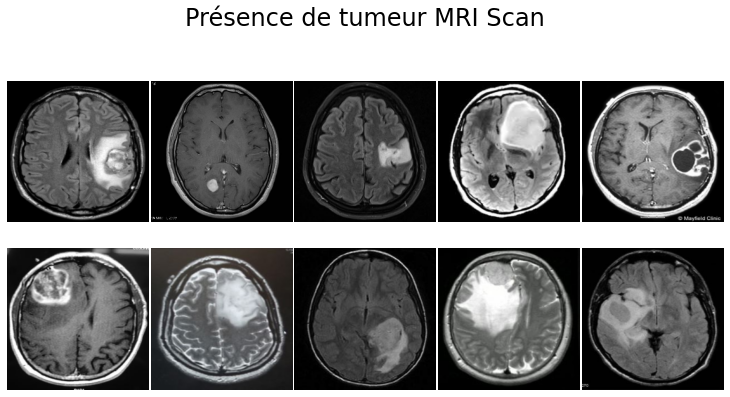

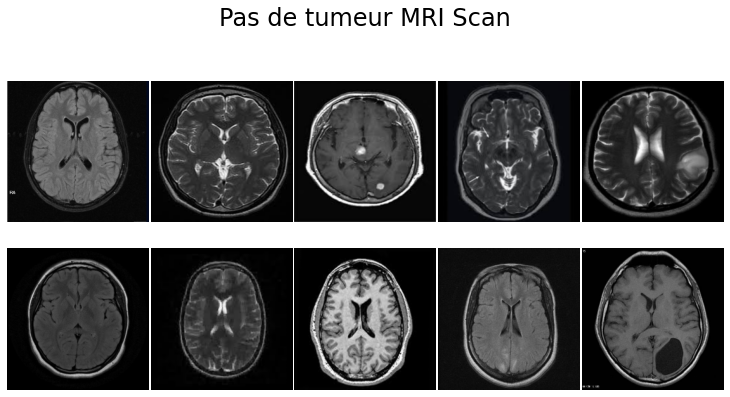

In [10]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 2, 5
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(tumor_images, 'Présence de tumeur MRI Scan')
plot_images(notumor_images, 'Pas de tumeur MRI Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [11]:
# Convert to array and Normalize to interval of [0,1]
tumor_images = np.array(tumor_images) / 255
notumor_images = np.array(notumor_images) / 255

### **Train Test Split**

In [12]:
# Split into training and testing sets for both types of images
tumor_x_train, tumor_x_test, tumor_y_train, tumor_y_test = train_test_split(
    tumor_images, tumor_labels, test_size=0.2)
notumor_x_train, notumor_x_test, notumor_y_train, notumor_y_test = train_test_split(
    notumor_images, notumor_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((notumor_x_train, tumor_x_train), axis=0)
X_test = np.concatenate((notumor_x_test, tumor_x_test), axis=0)
y_train = np.concatenate((notumor_y_train, tumor_y_train), axis=0)
y_test = np.concatenate((notumor_y_test, tumor_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

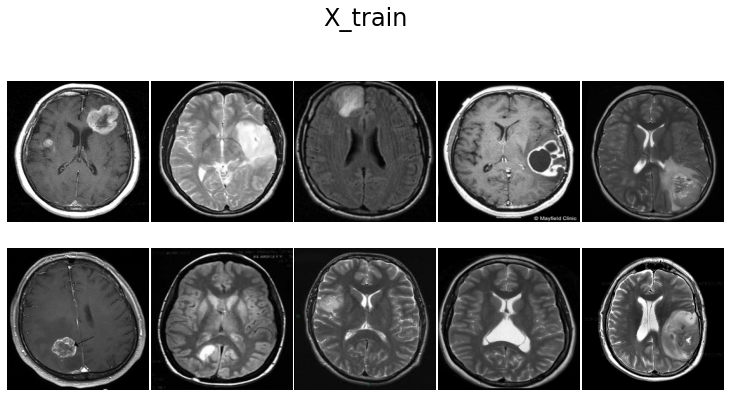

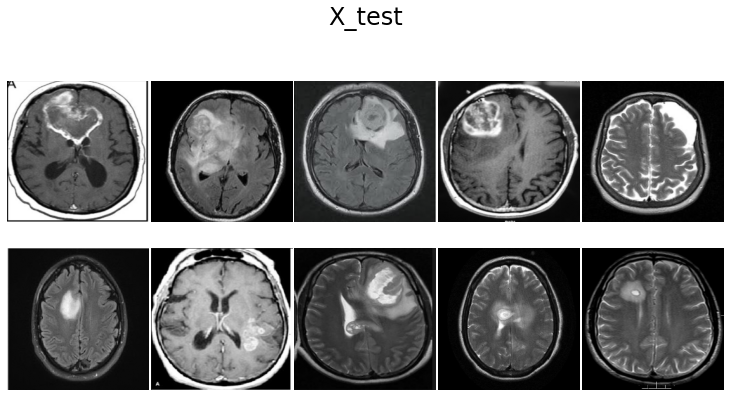

In [13]:
plot_images(tumor_x_train, 'X_train')
plot_images(tumor_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

#Pré-Trained Modele : Xception 

In [31]:
from tensorflow.keras.applications import Xception

### **Building and Visualizing model**

In [14]:
# Building Model
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

83689472/83683744 [==============================] - 1s 0us/step


In [15]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

### **Image Augmentation**
To train on images at different positions, angles, flips, etc

In [16]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [17]:
batch_size = 32
epochs = 10
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/10
6/6 [==============================] - 12s 611ms/step - loss: 1.8703 - accuracy: 0.5367 - val_loss: 2.0109 - val_accuracy: 0.7843
Epoch 2/10
6/6 [==============================] - 2s 367ms/step - loss: 1.2321 - accuracy: 0.7505 - val_loss: 2.3330 - val_accuracy: 0.7647
Epoch 3/10
6/6 [==============================] - 2s 375ms/step - loss: 1.1209 - accuracy: 0.8365 - val_loss: 2.1601 - val_accuracy: 0.7843
Epoch 4/10
6/6 [==============================] - 2s 381ms/step - loss: 0.7476 - accuracy: 0.8241 - val_loss: 1.7332 - val_accuracy: 0.8235
Epoch 5/10
6/6 [==============================] - 2s 425ms/step - loss: 0.5627 - accuracy: 0.8991 - val_loss: 1.9342 - val_accuracy: 0.7647
Epoch 6/10
6/6 [==============================] - 2s 364ms/step - loss: 0.5780 - accuracy: 0.8823 - val_loss: 1.5116 - val_accuracy: 0.8235
Epoch 7/10
6/6 [==============================] - 2s 424ms/step - loss: 0.1821 - accuracy: 0.9197 - val_loss: 1.2777 - val_accuracy: 0.8627
Epoch 8/10
6/6 [===

In [18]:
# Save Model and Weights
model.save('xception_rmi.h5')
model.save_weights('xception_weights_rmi.hdf5')

In [19]:
# Load saved model
model = load_model('xception_rmi.h5')

### **Making Predicions**

In [20]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

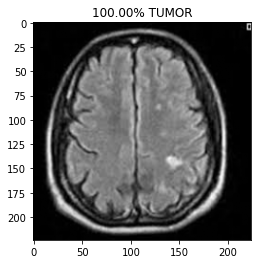

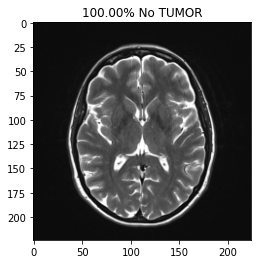

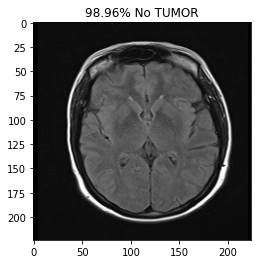

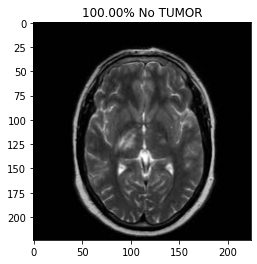

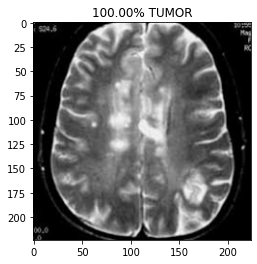

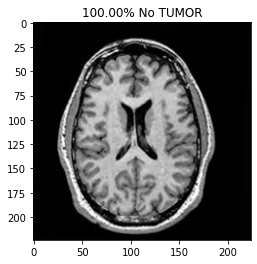

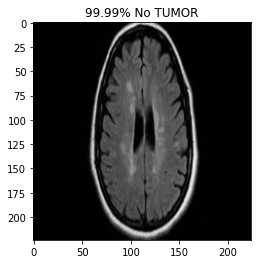

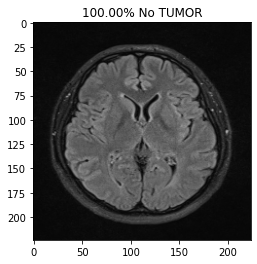

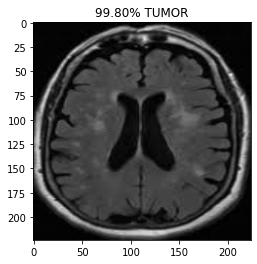

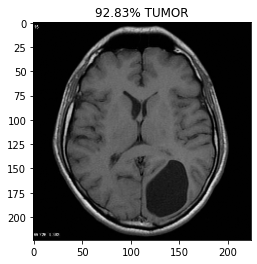

In [21]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% TUMOR')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% No TUMOR')
  plt.imshow(X_test[index])
  plt.show()

In [22]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

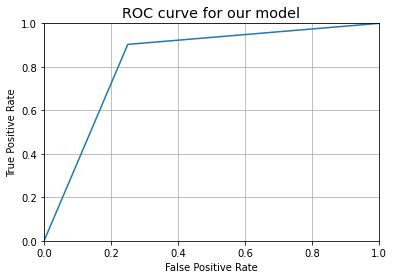

In [23]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


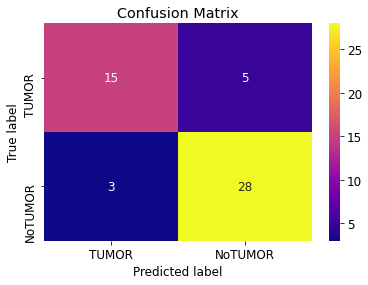

Confusion Matrix with Normalized Values


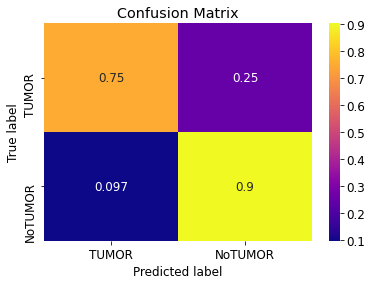

In [24]:
def plot_confusion_matrix(normalize):
  classes = ['TUMOR','NoTUMOR']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.85      0.90      0.88        31

    accuracy                           0.84        51
   macro avg       0.84      0.83      0.83        51
weighted avg       0.84      0.84      0.84        51



### **Accuracy and Loss Plots**

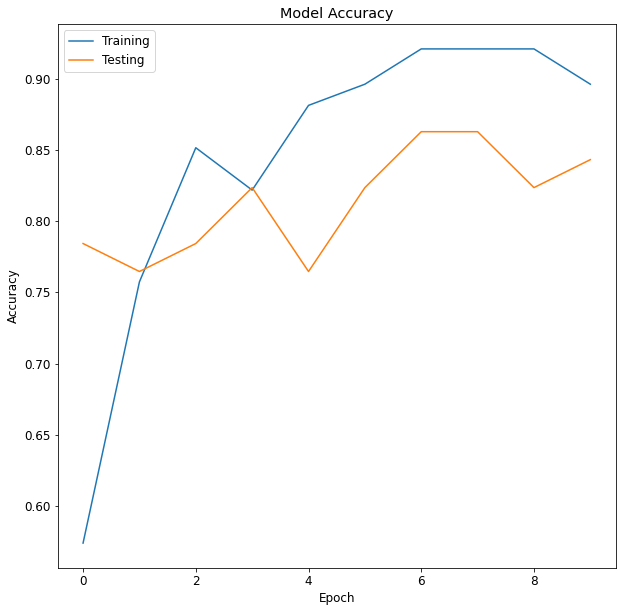

In [26]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_ct_accuracy.png')
plt.show()


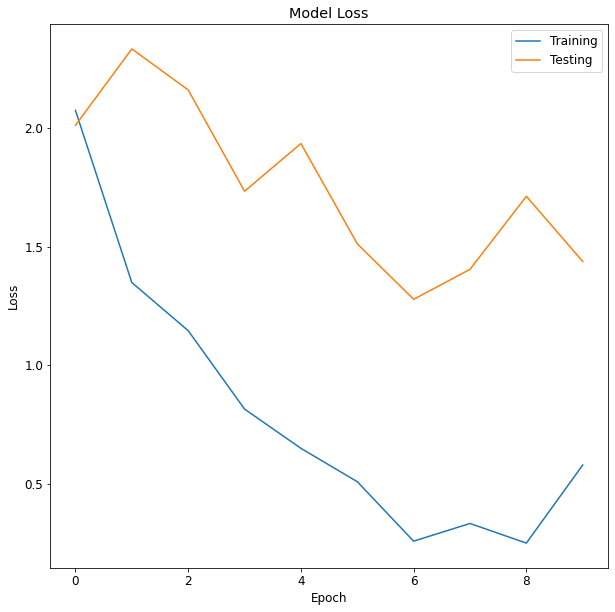

In [27]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_ct_loss.png')
plt.show()

#Pré-Trained Modele : InceptionV3

In [29]:
from tensorflow.keras.applications import InceptionV3

In [30]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87916544/87910968 [==============================] - 1s 0us/step


In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 111, 111, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

In [33]:
history2 = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/10
6/6 [==============================] - 8s 684ms/step - loss: 3.0112 - accuracy: 0.6404 - val_loss: 1.0955 - val_accuracy: 0.7647
Epoch 2/10
6/6 [==============================] - 2s 405ms/step - loss: 2.2704 - accuracy: 0.7188 - val_loss: 1.5340 - val_accuracy: 0.8235
Epoch 3/10
6/6 [==============================] - 2s 360ms/step - loss: 1.8256 - accuracy: 0.8078 - val_loss: 1.1932 - val_accuracy: 0.8235
Epoch 4/10
6/6 [==============================] - 2s 361ms/step - loss: 2.0810 - accuracy: 0.7974 - val_loss: 1.7978 - val_accuracy: 0.6667
Epoch 5/10
6/6 [==============================] - 2s 373ms/step - loss: 0.8459 - accuracy: 0.8277 - val_loss: 0.8915 - val_accuracy: 0.8627
Epoch 6/10
6/6 [==============================] - 2s 367ms/step - loss: 0.7583 - accuracy: 0.8916 - val_loss: 0.6769 - val_accuracy: 0.8824
Epoch 7/10
6/6 [==============================] - 2s 371ms/step - loss: 0.6429 - accuracy: 0.9013 - val_loss: 0.5398 - val_accuracy: 0.8627
Epoch 8/10
6/6 [====

In [34]:
# Save Model and Weights
model.save('inceptionV3_rmi.h5')
model.save_weights('inceptionV3_weights_rmi.hdf5')

# Load saved model
model = load_model('inceptionV3_rmi.h5')

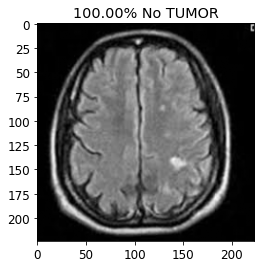

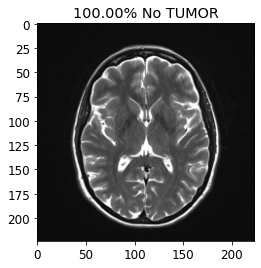

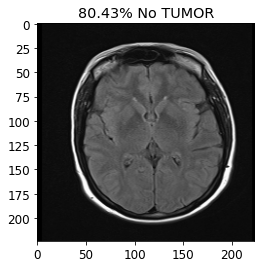

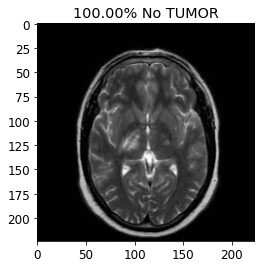

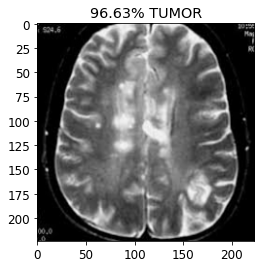

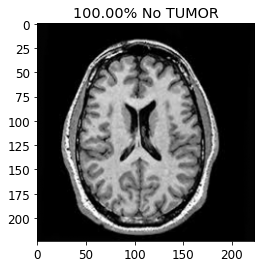

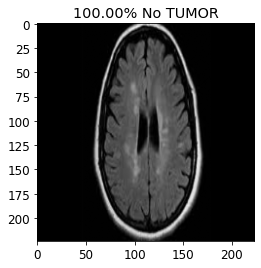

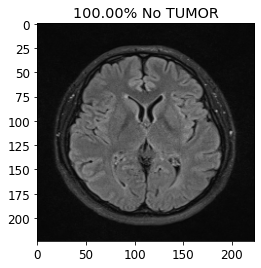

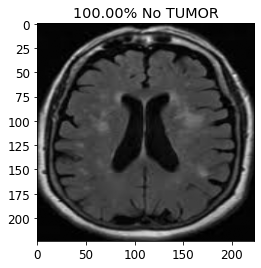

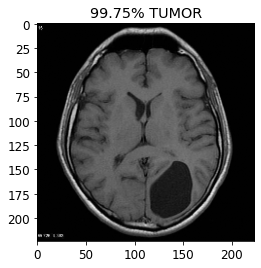

In [35]:
#Prédiction 
y_pred = model.predict(X_test, batch_size=batch_size)

#Visualiser les 10 premiers prédiction 
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% TUMOR')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% No TUMOR')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

Confusion Matrix without Normalization


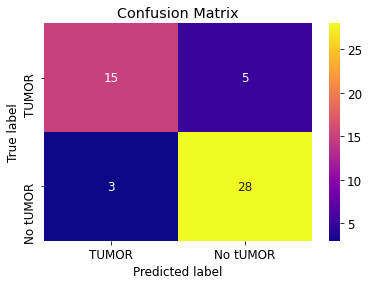

Confusion Matrix with Normalized Values


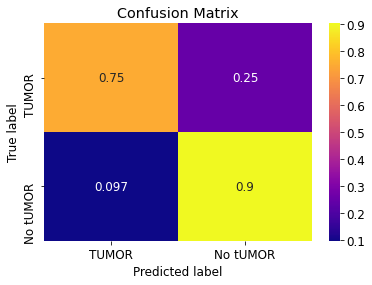

In [36]:
#Plot confusion matrix
def plot_confusion_matrix(normalize):
  classes = ['TUMOR','No tUMOR']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [37]:
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.85      0.90      0.88        31

    accuracy                           0.84        51
   macro avg       0.84      0.83      0.83        51
weighted avg       0.84      0.84      0.84        51



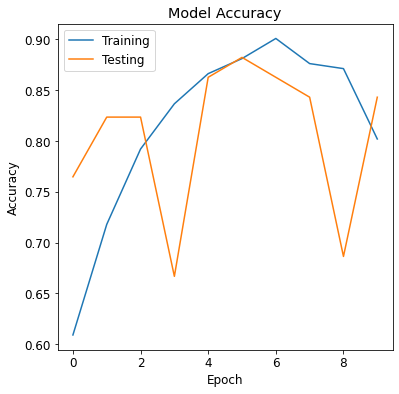

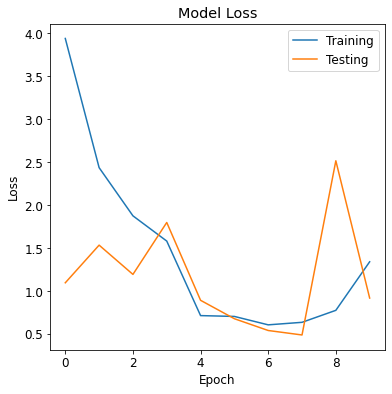

In [40]:
#Accuracy  plot 
plt.figure(figsize=(6,6))

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_accuracy.png')
plt.show()

#Loss plot
plt.figure(figsize=(6,6))

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_loss.png')
plt.show()